# Main Notebook: Embeddings

## 1. Setup Instructions

### A. Rust LZ78 Library
You need to install Rust and Maturin, and then install the Python bindings for the `lz78` library as an editable Python package.
1. Install Rust: [Instructions](https://www.rust-lang.org/tools/install).
    - After installing Rust, close and reopen your terminal before proceeding.
2. If applicable, switch to the desired Python environment.
3. Install Maturin: `pip install maturin`
4. Install the `lz78` Python package: `cd crates/python && maturin develop -r && cd ../..`

**NOTE**: If you use virtual environments, you may run into an issue. If you are a conda user, it's possible the `(base)` environment may be activated on startup. `maturin` does not allow for two active virtual environments (ie. via `venv` and `conda`). You must make sure only one is active. One solution is to run `conda deactivate` in preference of your `venv` based virtual environment.

**NOTE**: If you are using MacOS, you may run into the following error with `maturin develop`:
```
error [E0463]: can't find crate for core
    = note: the X86_64-apple-darwin target may not be installed
    = help: consider downloading the target with 'rustup target add x86_64-apple-darwin'
```
Running the recommended command `rustup target add x86_64-apple-darwin` should resolve the issue.

### B. LZ78 Embeddings
From the root directory of the repository, run
```
pip install --editable .
```

### **Warning**
Sometimes, Jupyter doesn't register that a cell containing code from the `lz78` library has started running, so it seems like the cell is waiting to run until it finishes.
This can be annoying for operations that take a while to run, and **can be remedied by putting `stdout.flush()` at the beginning of the cell**.

## 2. Imports

In [ ]:
from lz_embed.classical import NGramSpectrumEmbedding, NGramSpectrumEmbeddingConfig
import mteb
from sys import stdout, stderr
from lz_embed.transformer_based import TokenizedLZPlusEmbedding, TokenizedLZPlusEmbeddingConfig, WeightType
from lz_embed.utils import AlphabetInfo
import numpy as np
from relu_embed.embedding import NNEmbedding, NNEmbeddingConfig
from relu_embed.classification import MultiproblemReLUClassifier
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from relu_embed.data import DatasetInfo, load_and_process_dataset
import torch

In [ ]:
%load_ext autoreload
%autoreload 2

## 3. Summary
This notebook contains summaries of the different embedding techniques tried so far:

1. **NGram embedding**: this embedding method is equivalent to creating an embedding from the frequencies of each $n$-tuple in the input data (where $n$ is a small number, like 2).

2. **Combining LZ with a pretrained embedding model**: this is very similar to [Model2Vec](https://huggingface.co/blog/Pringled/model2vec). A priori, it computes the embedding of each token in the default Sentence Transformer vocabulary and performs PCA. At embedding time, it uses LZ probabilities to perform a weighted average of the token embeddings for the tokens in the input sequence.

3. **ReLU neural network embeddings**: a two-layer ReLU neural network embedding model is trained to provide embeddings for a variety of classification tasks (using a different classification head (linear layer + softmax) for each task).

### 3A. How to Run Experiments
For experiments, look at:
- **`scripts/train_model.py`**: this trains each of these three embedding models, and saves them to the specified directory, along with a model configuration JSON.

    After training, the model can be loaded in using `ModelClass.from_pretrained(directory)`, and the parameters can be changed within the `config.json` file.
    - For the NGram embeddings, it instantiates an NGram embedding model, and optionally uses data from the `Fineweb` dataset to compute a subspace on which the NGram embeddings are projected.
    - For the LZ embeddings, it trains an LZ tree on data from `Fineweb`.
    - For the ReLU NN embeddings, it trains a multi-headed classifier from which embeddings can be extracted.
- **`scripts/evaluate_model.py`**: this evaluates a pretrained embedding model on some tasks from the `mteb` benchmark.

### 3B: Model Instantiation
All models can generally be instantiated with code of the form
```
model = ModelClass(
    ModelClassConfig(options...),
    model_save_dir
)
```
Some models have training routines that are run post-instantiation.

To save the model so that it can be loaded from `model_save_dir` without specifying the configuration or training again, use
```
model.save_pretrained()
```
The model can then be loaded in with
```
model = ModelClass.from_pretrained(model_save_dir)
```

**Note**: `model_save_dir` will have a file called `config.json`, which can be modified to change the model configuration for the next time it is loaded in.

### 3C. Testing on MTEB Tasks
As all our embedding model classes inherit from `SentenceTransformer`, any MTEB task can be evaluated using the `mteb` library's interface.

Details about individual tasks can be found on the [MTEB leaderboard page](https://huggingface.co/spaces/mteb/leaderboard).

#### **Disclaimer: this is preliminary work, and not very well polished, documented, or debugged.**


## 4. NGram Embedding

To instantiate a `BasicLZSpectrum`, you need to specify information about the alphabet of the sequences you are encoding.
This is via the `AlphabetInfo` dataclass, where you specify either:
1. `AlphabetInfo(alphabet_size=A)`, for encoding integer sequences, or
2. `AlphabetInfo(valid_character_string="abcdefgh...")` for encoding strings. This specifies that strings being encoded can only consist of characters in `valid_character_string`.

You also have to specify what `n` to use for the `n`-gram. Something small, like 2, is recommended because the embedding dimension is exponetial in `n`.

#### **Note**: PCA
You can perform PCA (using embeddings from calibration data sampled from `Fineweb`) to reduce the large dimensionality (17k for $n=2$) of the ngram embedding. See `scripts/train_model.py` for more details.

In [ ]:
model = NGramSpectrumEmbedding(
    NGramSpectrumEmbeddingConfig(
        alphabet_info=AlphabetInfo(valid_character_string="abcdefghijklmnopqrstuvwxyz"),
        n=2
    ),
    "object/ngram"
)

#### **Quick example**: `save_pretrained` and `load_pretrained`

In [ ]:
model.save_pretrained()

In [ ]:
model = NGramSpectrumEmbedding.from_pretrained("object/ngram")

#### **Example**: computing embeddings

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(model.encode([
    "Hello world hello world I am a hello of the world hello hello world world wow wow hello hello"
])[0])

In [ ]:
plt.figure(figsize=(12,3))
plt.plot(model.encode([
    "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."
])[0])

### Try on some of the MTEB tasks

This does surprisingly well for a 2-gram model (3-gram is slow and the embeddings are prohibitively large).

Results here: [link](https://docs.google.com/spreadsheets/d/11CBoRJ33tmXQqd50IVaWbFn915fD90Het3DKSTW8F78/edit?usp=sharing)

In [ ]:
task_list = [
    "ArXivHierarchicalClusteringP2P",
    "FinancialPhrasebankClassification",
    "PoemSentimentClassification"
    "HagridRetrieval",
]

outputs = []

for task in task_list:
    tasks = mteb.get_tasks(tasks=[task])
    evaluation = mteb.MTEB(tasks=tasks)

    results = evaluation.run(
        model, output_folder=f"results/test",
        show_progress_bar=False,
        overwrite_results=True
    )

    score = np.mean([results[0].scores[name][0]["main_score"] * 100 for name in results[0].scores])
    outputs.append(score)
    print("SCORE: ", score)
    stdout.flush()

## 5. LZ Weighted Embedding
This does the following:
1. Computes embeddings for all tokens in (e.g.) the BERT vocabulary and performs PCA, just like the Potion models. 

    _Note_: this part is currently suboptimal compared to the Potion models, which do an additional round of finetuning for the stored embeddings. We can do this too, but it would make the initial experiment cycle quite unwieldy.

2. Trains an LZ78 SPA on some data (making everything lowercase and omitting everything that isn't a letter, number, or space)

3. Computes embeddings by taking the weighted average of the stored embeddings over the tokens in the input sequences.
Here, we have the option to use uniform weighting, Zipf weighting (which should be equivalent to the Potion models, minus the finetuning), or LZ log loss weighing.

Theoretically, the LZ log loss weighting should be better, but in practice it isn't clearly better than zipf. It's better than uniform weighting, which is at least a step in the right direction.

In [ ]:
model = TokenizedLZPlusEmbedding( 
    TokenizedLZPlusEmbeddingConfig(
        inner_model_name="BAAI/bge-base-en-v1.5",
        backshift_and_ensemble=True,
        backshift_parsing_len=10,
        ensemble_n=6,
        spa_lower_bound=1e-3,
        pca=True,
        pca_dim=256,
        weight_type=WeightType.LOG_LOSS,
        device="cuda:7"
    ),
    "object/lz"
)

#### **Simple Training**: Train on Wikipedia

In [ ]:
dataset = load_dataset("salesforce/Wikitext", "wikitext-2-v1")
EPOCHS = 10
stdout.flush()
for _ in tqdm(range(EPOCHS)):
    for text in (dataset["train"]):
        text = text["text"]
        if not text:
            continue
        model.train_spa(text)

In [ ]:
stdout.flush()
model.spa.prune(2)
print(f"The LZ tree has {model.spa.get_total_nodes() / 1e6} million nodes")

### Try on some of the MTEB tasks

In [ ]:
task_list = [
    "ArXivHierarchicalClusteringP2P",
    "FinancialPhrasebankClassification",
    "PoemSentimentClassification"
    "HagridRetrieval",
]

outputs = []

for task in task_list:
    tasks = mteb.get_tasks(tasks=[task])
    evaluation = mteb.MTEB(tasks=tasks)

    results = evaluation.run(
        model, output_folder=f"results/test",
        show_progress_bar=False,
        overwrite_results=True
    )

    score = np.mean([results[0].scores[name][0]["main_score"] * 100 for name in results[0].scores])
    outputs.append(score)
    print("SCORE: ", score)
    stdout.flush()

## 6. Classification-Trained Embeddings

Potion can be thought of as a linear projection of token counts. A two-layer ReLU neural network should have more representation power, but it must be trained.

As an experiment in this direction, we train a classifier to do well on several classification tasks from MTEB with the following architecture:

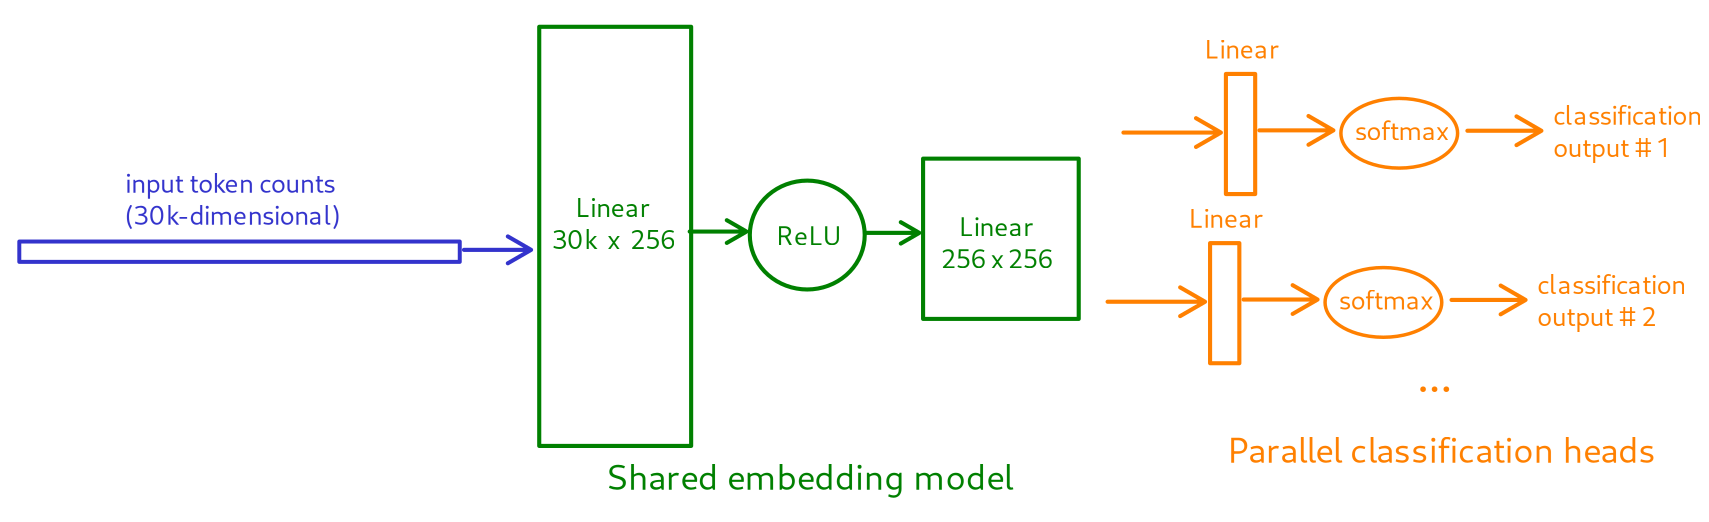

The embeddings are the output of the $256 \times 256$ linear layer, which are input, in parallel, to several linear classification heads.

This will train an embedding model that is well-suited for linear classifiers (at least for some problems), but it doesn't (empirically) generalize well to other problem types, or even clustering-based classifiers.

### Step 1: Get data

In [ ]:
problems = [
    DatasetInfo("mteb/banking77"),
    DatasetInfo("mteb/amazon_counterfactual"),
    DatasetInfo("mteb/toxic_conversations_50k"),
    DatasetInfo(
        "google-research-datasets/poem_sentiment", text_column="verse_text"),
    DatasetInfo(
        "takala/financial_phrasebank", name="sentences_allagree",
        text_column="sentence", has_splits=False),
    DatasetInfo("mteb/imdb"),
    DatasetInfo("mteb/tweet_sentiment_extraction"),
    
]
problem_names = [x.dataset for x in problems]

n_classes = []
Xs, ys, Xtests, ytests, ids = [], [], [], [], []
for (i, prob) in enumerate(problems):
    X, y, Xtest, ytest = load_and_process_dataset(prob)
    n_classes.append(int(torch.max(y).item()) + 1)
    Xs.append(X)
    ys.append(y)
    Xtests.append(Xtest)
    ytests.append(ytest)
    ids.append(i)

### Step 2: Train a classifier

For reference, based on the MTEB leaderboard, the potion models get the following accuracies:
- **Amazon counterfactual**: 66%
- **Toxic conversations**: 69%
- **Financial phrasebank**: 65%
- **Poem sentiment**: 45%

(I couldn't find the rest of the problems used on the leaderboard)

In [ ]:
model = MultiproblemReLUClassifier(
    n_classes=n_classes, problem_names=problem_names,
    input_size=Xs[0].shape[1],
    embedding_size=256,
    device="cuda:7"
)

In [ ]:
train_dataloader = model.get_dataloader_batch(
    Xs, ys, ids, batch_size=256, normalize_rows=True
)
test_dataloaders = [
    model.get_dataloader_single(
        Xtest, ytest, id_test, batch_size=256, normalize_rows=True
    ) for (Xtest, ytest, id_test) in zip(Xtests, ytests, ids)
]

In [ ]:
model.train(
    train_dataloader, test_dataloaders,
    epochs=15, lr=1e-3,
    lr_decay=0.99,
    eval_interval=200_000
)

### Step 3: Make an embedding model

In [ ]:
embedding_model = model.get_embedding_model(
    NNEmbeddingConfig(
        tokenizer_name="BAAI/bge-base-en-v1.5",
        embedding_dimension=model.embedding_size,
        normalize_token_counts=True,
        normalize_embeds=True,
        device="cpu"
    ), "object/relu"
)

#### **Note**: discrepancy in accuracies
The eval accuracy of the multiheaded classifier is not indicative of the eval loss when evaluating the model on the corresponding MTEB tasks. MTEB might be using a clustering-based classifier instead of a regression-based classifier.

In [ ]:
task_list = [
    "PoemSentimentClassification",
    "FinancialPhrasebankClassification",
]

outputs = []

for task in task_list:
    tasks = mteb.get_tasks(tasks=[task])
    evaluation = mteb.MTEB(tasks=tasks)

    results = evaluation.run(
        embedding_model, output_folder=f"results/test",
        show_progress_bar=True,
        overwrite_results=True
    )

    score = np.mean([results[0].scores[name][0]["main_score"] * 100 for name in results[0].scores])
    outputs.append(score)
    print("SCORE: ", score)
    stdout.flush()